In [67]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.interpolate import interp1d

from ipywidgets import FloatProgress
from IPython.display import display

# Analysis of inter-dependance

Most general formulation: Let there be $N$ time-dependent observables, that are observed simultaneously at discrete time points. The future values of each observable depends on its own history, the history of all other observables, and also the history of other, non-observed objects. It is of interest to discover completely the equations of motion of the system, which may be exact or probabilistic. Clearly, any finite amount of data can be explained by an infinite number of equally valid equations of motion, so the exact answer to the problem depends on having a strong underlying model and is to some extend arbitrary and philosophical (e.g. to use or not to use Occam's razor). But data always comes before the model. First, exploratory model-free analysis is necessary to get intuition of which models are possible. In particular, it is useful to determine, which observables are independent, which are weakly or strongly dependent on each other. Formally this is also impossible, since even random finite data could be explained by a very complicated dependence function. Also, in order to make any progress on this problem, the laws governing the interaction of the system with any non-observed systems must be completely known a priori. For example, all observables can in general be explained solely by external input, providing zero information about the interactions within the system. Typically it is assumed that there is no external input, external input is random with a known distribution, or, if we are lucky, external input can be manipulated by the observer. In this exercise, we will start from the other end - assuming a very simple setup first, progressively relaxing assumptions.

At first, let us assume two observables, $X$ and $Y$, produce independent and identically distributed (i.i.d) samples from the joint probability distribution $\rho(x,y)$. For such observables, the question of interest is whether they are independent ($\rho(x,y) = \rho(x)\rho(y)$) or not.


### Correlation
The most common metric for testing this dependence is correlation. Defined as

$CORR(X,Y) = \frac{COV(X,Y)}{\sigma_X \sigma_Y}
= \frac{1}{\sigma_X \sigma_Y} \int_x \int_y \rho(x,y) (x-\mu_x)(y-\mu_y) dx dy$

An empirical estimator for correlation is given by

$CORR(x, y) = \frac{COV(x, y)}{s_x s_y} = \frac{1}{s_x s_y} \sum_i \frac{1}{N-1} (x_i-\bar{x})(y_i-\bar{y})$

It is easy to show that $CORR(X,Y) = 0$ for independent observables. This means that non-zero correlation indicates dependence of variables. The typical problems of correlation are:
* $CORR=0$ does not prove that variables are independent, only that the linear part of their possible dependence function is zero. It is frequently a misleading metric
* Estimators of correlation are typically non-zero for independent observables due to finite sample size. Weakly correlated observables require a lot of data samples for high confidence, although this is true for any metric.
* It is quite sensitive to the i.i.d assumption. Covariance is not defined for such data, and in practice the estimator can report very high spurious correlation for independent but time-dependent sequences.

### Spearmann Rank (SR)

Similar to correlation, but it can check if observables are monotonously dependent, which is a stronger test than linearity. It suffers from the same shortcomings as correlation.
* Is SR formally applicable to continous data? Is binning used in estimator? Does it depend on bin size?
* Does SR require more data for the same confidence level, given that the claim is stronger? I don't see any difference in the error curve.



### Partial autocorrelation

Find out what it means
* https://en.wikipedia.org/wiki/Partial_autocorrelation_function

### Sanity check 1:

Verify that numpy correlation coefficient matches the explicit formula.

**Conclusion**: All estimators are more or less the same, using *np.corrcoef* is faster than *np.cov*

Time for method 0 : 0.8041517734527588
Time for method 1 : 1.3897464275360107
Time for method 2 : 0.71840500831604


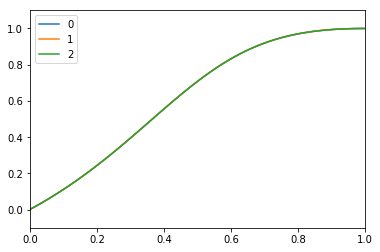

In [17]:
def corr1(x,y):
    return np.dot(x - np.average(x), y - np.average(y)) / np.std(x) / np.std(y) / (len(x) - 1)

def corr2(x,y):
    return np.cov(x,y)[0,1] / np.std(x) / np.std(y)

def corr3(x,y):
    return np.corrcoef(x,y)[0,1]

data = np.random.normal(0, 1, 1000000)
noise = np.random.normal(0, 1, 1000000)
ratio = np.linspace(0, 1, 100)
dataCorrupt = [data * p + noise * (1-p) for p in ratio]
method = [corr1, corr2, corr3]

plt.figure()

for i in range(len(method)):
    tstart = time()
    rez = [method[i](data, dataC) for dataC in dataCorrupt]
    print("Time for method", str(i), ":", time() - tstart)
    plt.plot(ratio, rez, label=str(i))    

plt.xlim((0, 1))
plt.ylim((-0.1, 1.1))
plt.legend()
plt.plot();

# print(scipy.stats.spearmanr(x,y)[0])
# print(scipy.stats.spearmanr(x,z)[0])

### Sanity Check 2.1:

Check the correlation and spearmann rank between two random datasets, depending on dataset size

**Conclusion:**
Correlation of completely random inputs drops roughly as $1 / (2\sqrt{N})$

Correlation fit: 0.56*x^-0.50
Spearmann fit: 0.52*x^-0.49


Text(0.5,1,'Spearmann Rank')

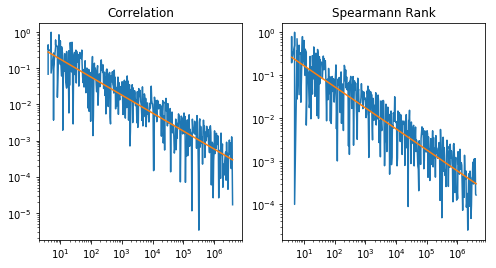

In [20]:
def loglogfit(x, y, name):
    coeff = np.polyfit(np.log(x), np.log(y), 1)
    curve = x**(coeff[0]) * np.exp(coeff[1])
    print(name + " fit: %.2f*x^%.2f" % (np.exp(coeff[1]), coeff[0]))
    return curve

nData = np.array([int(2**(2 + i / 20)) for i in range(400)])
corrData = np.zeros(len(nData))
sprData = np.zeros(len(nData))
for i in range(len(nData)):
    x = np.random.normal(0, 1, nData[i])
    y = np.random.normal(0, 1, nData[i])
    corrData[i] = np.abs(corr3(x,y))
    sprData[i] = np.abs(scipy.stats.spearmanr(x,y)[0])
    if sprData[i] == 0:
        sprData[i] = 1.0e-4
    
# Fit line to log-log plot of the resulting data
corrFit = loglogfit(nData, corrData, "Correlation")
sprFit = loglogfit(nData, sprData, "Spearmann")

fig, ax = plt.subplots(ncols = 2, figsize=(8, 4))
ax[0].loglog(nData, corrData)
ax[0].loglog(nData, corrFit)
ax[0].set_title("Correlation")
ax[1].loglog(nData, sprData)
ax[1].loglog(nData, sprFit)
ax[1].set_title("Spearmann Rank");

### Sanity Check 2.2:

Check the correlation and spearmann rank between two Wiener processes, depending on dataset size

**Conclusion:**
Wiener processes have non-converging mean and variance. Correlation is not applicable to them, because they strongly violate the i.i.d assumption. It is observed that the absolute value of correlation between two completely random processes fluctuates about 0.5, and can be easily mistaken for genuine dependence

Correlation fit: 0.29*x^0.00
Spearmann fit: 0.29*x^-0.00


Text(0.5,1,'Spearmann Rank')

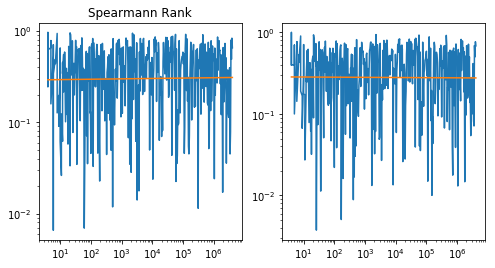

In [21]:
# 2) Test dependence of random correlation on size
nData = np.array([int(2**(2 + i / 20)) for i in range(400)])
corrData = np.zeros(len(nData))
sprData = np.zeros(len(nData))
for i in range(len(nData)):
    x = np.random.normal(0, 1, nData[i])
    y = np.random.normal(0, 1, nData[i])
    
    # Convert random data into Markov chains
    for j in range(1, nData[i]):
        x[j] += x[j-1]
        y[j] += y[j-1]
    
    corrData[i] = np.abs(corr3(x,y))
    sprData[i] = np.abs(scipy.stats.spearmanr(x,y)[0])
    if sprData[i] == 0:
        sprData[i] = 1.0e-4
    
# Fit line to log-log plot of the resulting data
corrFit = loglogfit(nData, corrData, "Correlation")
sprFit = loglogfit(nData, sprData, "Spearmann")

fig, ax = plt.subplots(ncols = 2, figsize=(8, 4))
ax[0].loglog(nData, corrData)
ax[0].loglog(nData, corrFit)
ax[0].set_title("Correlation")
ax[1].loglog(nData, sprData)
ax[1].loglog(nData, sprFit)
ax[0].set_title("Spearmann Rank")

### Sanity Check 2.3:

Check the correlation and spearmann rank between two processes with exponentially decaying response (lag), depending on dataset size

**Conclusion:**
Laggy process does converge, but requires orders of magnitude more data, depending on the lag

FloatProgress(value=0.0, max=700.0)

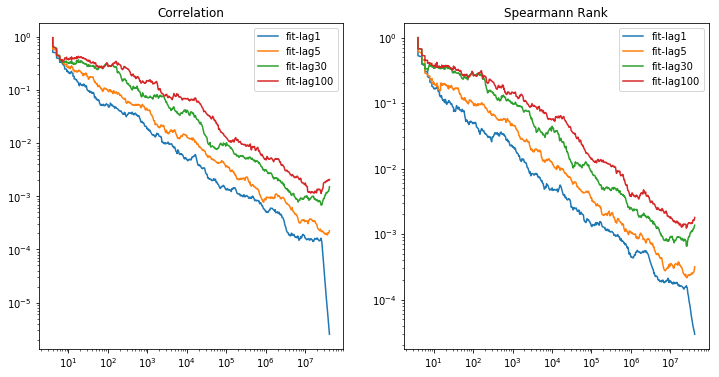

In [78]:
def smoothWindow(data, windowSize):
    gap = windowSize // 2
    rez = np.zeros(len(data)+1)
    tmp = np.zeros(len(data) + 2*gap)
    tmp[:gap] = 2*data[0] - data[:gap][::-1]
    tmp[-gap:] = 2*data[-1] - data[-gap:][::-1]
    tmp[gap:-gap] = data
    
    for i in range(len(data)+1):
        rez[i] = np.average(tmp[i:i+windowSize])
        
    # Problem: resulting array is 1 point longer than source. Need to reinterpolate
    xold = np.linspace(0, 1, len(data)+1)
    xnew = np.linspace(0, 1, len(data))
    f2 = interp1d(xold, rez, kind='cubic')
    return f2(xnew)


def approxDelayConv(data, TAU, DT):
    if TAU == 0:
        return data
    else:    
        rez = np.zeros(len(data)+1)
        for i in range(1, len(data)+1):
            rez[i] = data[i-1] + rez[i-1] * (1 - DT / TAU)

        return rez[1:]


DT = 1
nStep = 700
nData = np.array([int(2**(2 + i / 30)) for i in range(nStep)])
Lag = [1, 5, 30, 100]

corrData = np.zeros((len(Lag), nStep))
sprData = np.zeros((len(Lag), nStep))

progBar = FloatProgress(min=0, max=nStep) # instantiate the bar
display(progBar) # display the bar

for iData in range(len(nData)):
    progBar.value += 1
    
#     print("doing data size", nData[iData])
    x = np.random.normal(0, 1, nData[iData])
    y = np.random.normal(0, 1, nData[iData])

    for iLag in range(len(Lag)):
        # Convolve data with laggy kernel
        xLag = approxDelayConv(x, Lag[iLag], DT)
        yLag = approxDelayConv(y, Lag[iLag], DT)

        corrData[iLag][iData] = np.abs(corr3(xLag,yLag))
        sprData[iLag][iData] = np.abs(scipy.stats.spearmanr(xLag,yLag)[0])
        if sprData[iLag][iData] == 0:
            sprData[iLag][iData] = 1.0e-5
    
# Fit line to log-log plot of the resulting data
corrFit = np.zeros((len(Lag), nStep))
sprFit = np.zeros((len(Lag), nStep))
for iLag in range(len(Lag)):
    corrFit[iLag] = np.exp(smoothWindow(np.log(corrData[iLag]), 40))
    sprFit[iLag] = np.exp(smoothWindow(np.log(sprData[iLag]), 40))

fig, ax = plt.subplots(ncols = 2, figsize=(12, 6))
ax[0].set_title("Correlation")
ax[1].set_title("Spearmann Rank")
for iLag in range(len(Lag)):
#     ax[0].loglog(nData, corrData[iLag], label = "data-lag"+str(Lag[iLag]))
    ax[0].loglog(nData, corrFit[iLag], label = "fit-lag"+str(Lag[iLag]))
#     ax[1].loglog(nData, sprData[iLag], label = "data-lag"+str(Lag[iLag]))
    ax[1].loglog(nData, sprFit[iLag], label = "fit-lag"+str(Lag[iLag]))
ax[0].legend()
ax[1].legend();

### Sanity Check 3. 

Test dependence on variance of the data

**Conclusion**:
There is no observed dependence on relative scale, as expected

[ -2.04527069e-05   8.29207604e-03]


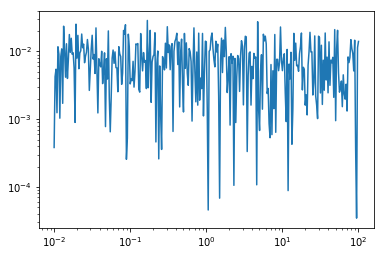

In [80]:
nData = 10**4
sigmaX = 1.0
sigmaYlst = [10**(i/80) for i in range(-160, 161)]
corrData = np.zeros(len(sigmaYlst))

for i in range(len(sigmaYlst)):
    sigmaY = sigmaYlst[i]
    x = np.random.normal(0, sigmaX, nData)
    y = np.random.normal(0, sigmaY, nData)
    corrData[i] = np.abs(corr3(x,y))

print(np.polyfit(sigmaYlst, corrData, 1))
    
plt.figure()
plt.loglog(sigmaYlst, corrData)
plt.show()

Let's try to do exactly what Spearmann should be good at - monotonic dependence

0.6619681590427127
1.0


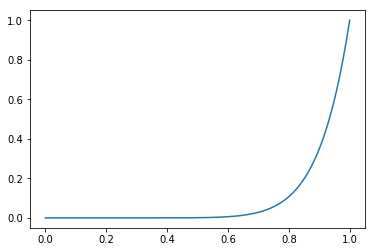

In [20]:
x = np.linspace(0, 1, 1000)
# y = 1.0 / (np.exp(-40*(x-0.5)) + 1
y = x**10

print(corr(x,y))
print(scipy.stats.spearmanr(x,y)[0])

plt.figure()
plt.plot(x,y)
plt.show()

So Spearmann Rank is strictly better than correlation coefficient for recovering dependence. How about some evil data

-2.8450202236879124e-17
0.002657046339713177


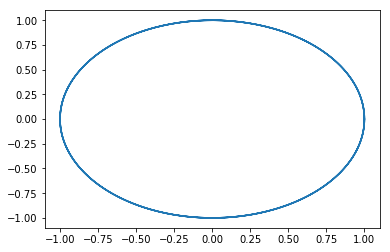

In [22]:
x = np.linspace(0, 1, 1000)
y = np.cos(6 * np.pi * x)
z = np.sin(6 * np.pi * x)

print(corr(y,z))
print(scipy.stats.spearmanr(y,z)[0])

plt.figure()
plt.plot(y,z)
plt.show()

# Not a chance :D

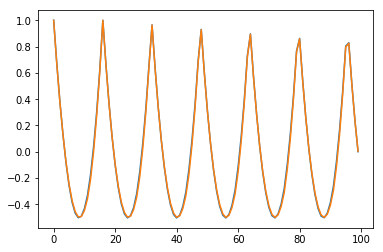

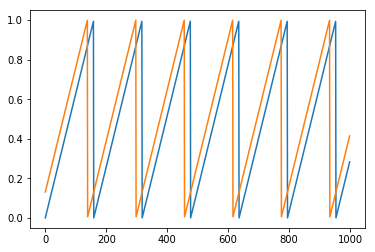

In [31]:
# How about some cyclic time-shifting
x = np.linspace(0, 1, 1000)
y = 2 * np.pi * x % 1
corrList1 = []
corrList2 = []

for i in range(100):
    phi = 2 * np.pi * i / 100
    z = (2 * np.pi * x + phi) % 1
    corrList1.append(corr(y,z))
    corrList2.append(scipy.stats.spearmanr(y,z)[0])

plt.figure()
plt.plot(corrList1)
plt.plot(corrList2)
plt.show()

plt.figure()
plt.plot(y)
plt.plot((2 * np.pi * x + 2 * np.pi * 18 / 100) % 1)
plt.show()



Cool, so time-shifting of smooth time-delayed functions monotonically increases towards correct delay reversal. Lets try a stochastic time-delayed function instead.

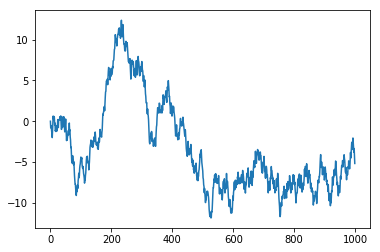

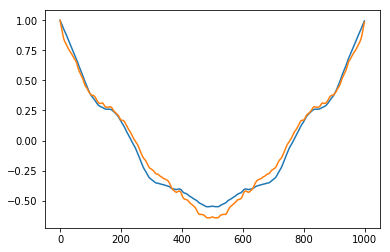

In [37]:
# Create a markov chain
x = np.linspace(0, 1, 1000)
y1 = np.random.uniform(-1, 1, 1000)
y2 = np.zeros(1000)
for i in range(1, 1000):
    y2[i] = y2[i-1] + y1[i-1]
    
plt.figure()
plt.plot(y2)
plt.show()

corrList1 = []
corrList2 = []

for i in range(1000):
    z = np.array([y2[(j + i) % 1000] for j in range(1000)])
    corrList1.append(corr(y2,z))
    corrList2.append(scipy.stats.spearmanr(y2,z)[0])

plt.figure()
plt.plot(corrList1)
plt.plot(corrList2)
plt.show()

Result: Lol, it even works linearly with chains. What about purely random data?
    

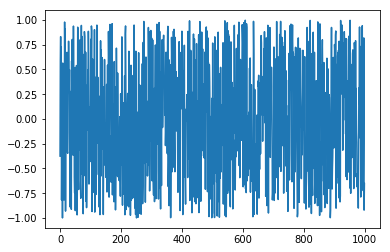

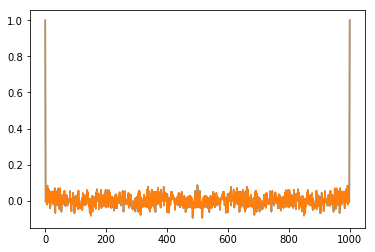

In [39]:
# Create a markov chain
x = np.linspace(0, 1, 1000)
y = np.random.uniform(-1, 1, 1000)
    
plt.figure()
plt.plot(y)
plt.show()

corrList1 = []
corrList2 = []

for i in range(1001):
    z = np.array([y[(j + i) % 1000] for j in range(1000)])
    corrList1.append(corr(y,z))
    corrList2.append(scipy.stats.spearmanr(y,z)[0])

plt.figure()
plt.plot(corrList1)
plt.plot(corrList2)
plt.show()

Conclusion: If any amount of smoothness can be assumed about dependent functions, then the maximum correlation should increase gradually towards a global maximum, although some local maxima will also be present. However, with wildly varying functions there is no indication of improvement unless exactly the correct delay is hit